In [10]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached optree-0.15.0-cp312-cp312-win_amd64.whl.metadata (49 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
import os

In [4]:
# Hàm xử lý giá trị bị thiếu trước khi nội suy
def handle_nan(data):
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

    numeric_columns = ['Price', 'Open', 'High', 'Low']
    for col in numeric_columns:
        data[col] = data[col].astype(str).str.replace(',', '').astype(float)
        data[col] = data[col].interpolate(method='linear')
    
    data['CPIAUCSL'] = data['CPIAUCSL'].fillna(method='ffill') 
    data['CPIAUCSL'] = data['CPIAUCSL'].fillna(method='bfill') 
    return data

# Hàm nội suy dữ liệu cho một tập dữ liệu
def interpolate_dataset(data):
    data = data.sort_values('Date')
    data = handle_nan(data)

    start_date = data['Date'].min()
    end_date = data['Date'].max()
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    full_data = pd.DataFrame({'Date': all_dates})
    merged_data = full_data.merge(data, on='Date', how='left')

    numeric_columns = ['Price', 'Open', 'High', 'Low', 'Vol.']
    for col in numeric_columns:
        merged_data[col] = merged_data[col].interpolate(method='linear')

    merged_data['YearMonth'] = merged_data['Date'].dt.to_period('M')
    cpi_mapping = data.groupby(data['Date'].dt.to_period('M'))['CPIAUCSL'].first().to_dict()
    merged_data['CPIAUCSL'] = merged_data['YearMonth'].map(cpi_mapping)
    merged_data['Change %'] = merged_data['Price'].pct_change() * 100
    merged_data['Change %'] = merged_data['Change %'].apply(lambda x: f"{x:.2f}%" if not np.isnan(x) else np.nan)
    merged_data = merged_data.drop(columns=['YearMonth'])
    return merged_data


In [12]:
# Đọc và nội suy dữ liệu
train_data = pd.read_csv("C:/Users/gmgia/Documents/doanptkd/IS403.P23-Gold/Dataset/Splits/train_70_15_15.csv")
val_data = pd.read_csv("C:/Users/gmgia/Documents/doanptkd/IS403.P23-Gold/Dataset/Splits/val_70_15_15.csv")
test_data = pd.read_csv("C:/Users/gmgia/Documents/doanptkd/IS403.P23-Gold/Dataset/Splits/test_70_15_15.csv")

train_data = interpolate_dataset(train_data)
val_data = interpolate_dataset(val_data)
test_data = interpolate_dataset(test_data)

In [13]:
scaler_train = StandardScaler()
scaler_val = StandardScaler()
scaler_test = StandardScaler()

In [14]:
# Lấy cột Price và chuẩn hóa
train_prices = train_data['Price'].values.reshape(-1, 1)
val_prices = val_data['Price'].values.reshape(-1, 1)
test_prices = test_data['Price'].values.reshape(-1, 1)

scaled_train_prices = scaler_train.fit_transform(train_prices)
scaled_val_prices = scaler_val.fit_transform(val_prices)
scaled_test_prices = scaler_test.fit_transform(test_prices)


In [15]:
# Tạo chuỗi dữ liệu cho LSTM
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 90

# Tạo chuỗi cho từng tập
X_train, y_train = create_sequences(scaled_train_prices, time_steps)
X_val, y_val = create_sequences(scaled_val_prices, time_steps)
X_test, y_test = create_sequences(scaled_test_prices, time_steps)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 3820, Validation size: 733, Test size: 744


In [16]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 0.1731 - val_loss: 0.1569
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0254 - val_loss: 0.1231
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0237 - val_loss: 0.1111
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0190 - val_loss: 0.0972
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0206 - val_loss: 0.0893
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0182 - val_loss: 0.0821
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0179 - val_loss: 0.0768
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0158 - val_loss: 0.0726
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0148 - val_loss: 0.0675
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0149 - val_loss: 0.0644
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0130 - val_loss: 0.0624
Epoch 12/100
120/120 ━━━━━━━

In [18]:
# Dự đoán trên tập test
y_pred_scaled = model.predict(X_test)
y_pred = scaler_test.inverse_transform(y_pred_scaled)
y_test_actual = scaler_test.inverse_transform(y_test)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [22]:
# Tính các chỉ số đánh giá
# MAE
mae = mean_absolute_error(y_test_actual, y_pred)

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Tránh chia cho 0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if not np.any(y_true == 0) else np.inf

mape = mean_absolute_percentage_error(y_test_actual, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

# R^2
r2 = r2_score(y_test_actual, y_pred)

# Adjusted R^2
n = len(y_test_actual) 
p = 1  
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# In các chỉ số đánh giá
print("\nĐánh giá mô hình trên tập test:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.4f}")
print(f"Adjusted R^2: {adjusted_r2:.4f}")


Đánh giá mô hình trên tập test:
MAE: 12.68
MAPE: 0.54%
RMSE: 17.51
R^2: 0.9974
Adjusted R^2: 0.9974


In [20]:
# Dự đoán giá vàng cho 30, 60, 90 ngày tiếp theo
last_sequence = scaled_test_prices[-time_steps:]
future_predictions = []
num_days = 90

last_date = test_data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days, freq='D')

print("Dự báo 90 ngày tiếp theo:\n")
for day in range(num_days):
    current_sequence_reshaped = last_sequence.reshape((1, time_steps, 1))
    
    input_prices = scaler_test.inverse_transform(last_sequence.reshape(-1, 1)).flatten()
    next_pred = model.predict(current_sequence_reshaped, verbose=0)
    predicted_price = scaler_test.inverse_transform(next_pred)[0, 0]

    print(f"Ngày thứ {day + 1} ({future_dates[day].strftime('%Y-%m-%d')}):")
    print(f"Input (90 ngày trước đó): {input_prices}")
    print(f"Output (giá dự đoán): {predicted_price:.2f} USD\n")

    future_predictions.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_prices = scaler_test.inverse_transform(future_predictions)

last_date = test_data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days, freq='D')

future_30 = future_prices[:30]
future_60 = future_prices[:60]
future_90 = future_prices

Dự báo 90 ngày tiếp theo:

Ngày thứ 1 (2025-04-02):
Input (90 ngày trước đó): [2669.         2654.7        2652.26666667 2649.83333333 2647.4
 2665.4        2672.4        2690.8        2715.         2702.86666667
 2690.73333333 2678.6        2682.3        2717.8        2750.9
 2748.7        2757.925      2767.15       2776.375      2785.6
 2797.4        2778.3        2792.7        2779.26666667 2765.83333333
 2752.4        2781.         2781.5        2845.2        2835.
 2842.36666667 2849.73333333 2857.1        2875.8        2893.
 2876.7        2887.6        2903.2        2918.8        2934.4
 2932.6        2928.7        2945.4        2900.7        2912.775
 2924.85       2936.925      2949.         2936.1        2956.1
 2953.2        2952.03333333 2950.86666667 2949.7        2906.
 2917.8        2895.9        2848.5        2866.03333333 2883.56666667
 2901.1        2920.6        2926.         2926.6        2914.1
 2909.2        2904.3        2899.4        2920.9        2946.8
 2991.

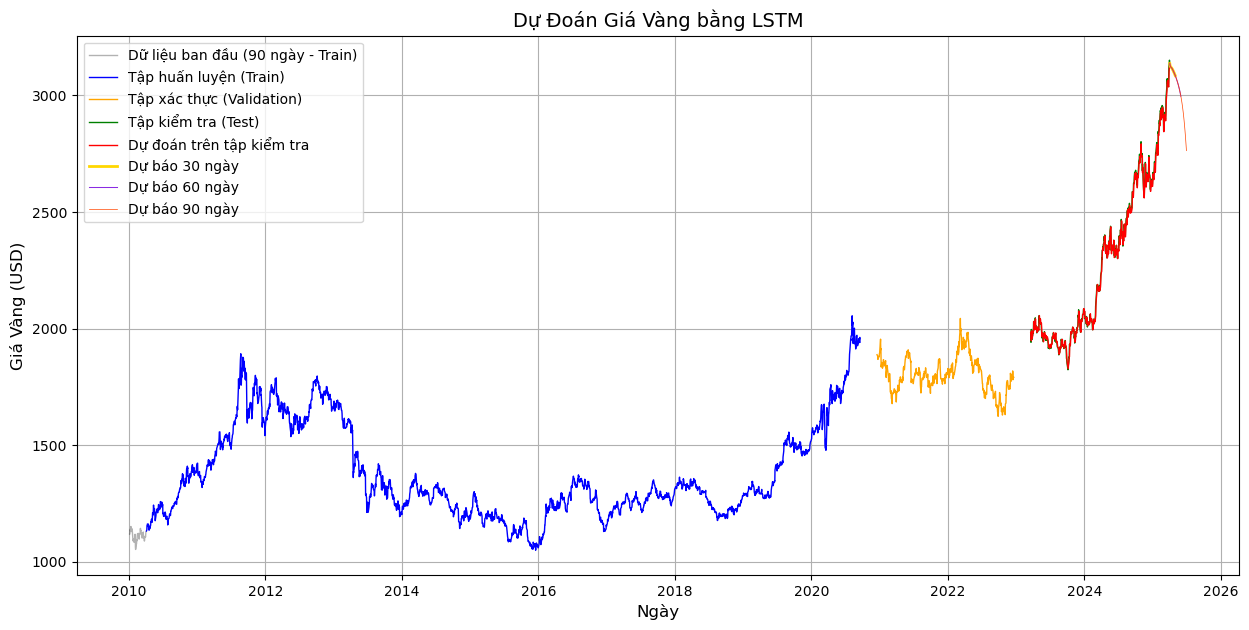

In [ ]:
# Chuẩn bị dữ liệu để vẽ biểu đồ
train_len = len(X_train)
val_len = len(X_val)
test_len = len(X_test)

train_dates = train_data['Date'][time_steps:time_steps + train_len]
val_dates = val_data['Date'][time_steps:time_steps + val_len]
test_dates = test_data['Date'][time_steps:time_steps + test_len]

train_actual = scaler_train.inverse_transform(scaled_train_prices[time_steps:time_steps + train_len])
val_actual = scaler_val.inverse_transform(scaled_val_prices[time_steps:time_steps + val_len])
test_actual = scaler_test.inverse_transform(scaled_test_prices[time_steps:time_steps + test_len])

# Vẽ biểu đồ
plt.figure(figsize=(15, 7))
plt.plot(train_data['Date'][:time_steps], scaler_train.inverse_transform(scaled_train_prices[:time_steps]), 'k-', label='Dữ liệu ban đầu (90 ngày - Train)', alpha=0.3, linewidth=1.0)
plt.plot(train_dates, train_actual, 'b-', label='Tập huấn luyện (Train)', linewidth=1.0)
plt.plot(val_dates, val_actual, 'orange', label='Tập xác thực (Validation)', linewidth=1.0)
plt.plot(test_dates, test_actual, 'g-', label='Tập kiểm tra (Test)', linewidth=1.0)
plt.plot(test_dates, y_pred, 'r-', label='Dự đoán trên tập kiểm tra', linewidth=1.0)
plt.plot(future_dates[:30], future_30, color='#FFD700', label='Dự báo 30 ngày', linewidth=2.0)
plt.plot(future_dates[:60], future_60, color='#8A2BE2', label='Dự báo 60 ngày', linewidth=0.75)
plt.plot(future_dates, future_90, color='#FF4500', label='Dự báo 90 ngày', linewidth=0.5)
plt.title('Dự Đoán Giá Vàng bằng LSTM', fontsize=14)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá Vàng (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()